# Welcome to the Data Science Coding Challange!

Test your skills in a real-world coding challenge. Coding Challenges provide CS & DS Coding Competitions with Prizes and achievement badges!

CS & DS learners want to be challenged as a way to evaluate if they’re job ready. So, why not create fun challenges and give winners something truly valuable such as complimentary access to select Data Science courses, or the ability to receive an achievement badge on their Coursera Skills Profile - highlighting their performance to recruiters.

## Introduction

In this challenge, you'll get the opportunity to tackle one of the most industry-relevant machine learning problems with a unique dataset that will put your modeling skills to the test. Financial loan services are leveraged by companies across many industries, from big banks to financial institutions to government loans. One of the primary objectives of companies with financial loan services is to decrease payment defaults and ensure that individuals are paying back their loans as expected. In order to do this efficiently and systematically, many companies employ machine learning to predict which individuals are at the highest risk of defaulting on their loans, so that proper interventions can be effectively deployed to the right audience.

In this challenge, we will be tackling the loan default prediction problem on a very unique and interesting group of individuals who have taken financial loans.

Imagine that you are a new data scientist at a major financial institution and you are tasked with building a model that can predict which individuals will default on their loan payments. We have provided a dataset that is a sample of individuals who received loans in 2021.

This financial institution has a vested interest in understanding the likelihood of each individual to default on their loan payments so that resources can be allocated appropriately to support these borrowers. In this challenge, you will use your machine learning toolkit to do just that!

## Understanding the Datasets

### Train vs. Test
In this competition, you’ll gain access to two datasets that are samples of past borrowers of a financial institution that contain information about the individual and the specific loan. One dataset is titled `train.csv` and the other is titled `test.csv`.

`train.csv` contains 70% of the overall sample (255,347 borrowers to be exact) and importantly, will reveal whether or not the borrower has defaulted on their loan payments (the “ground truth”).

The `test.csv` dataset contains the exact same information about the remaining segment of the overall sample (109,435 borrowers to be exact), but does not disclose the “ground truth” for each borrower. It’s your job to predict this outcome!

Using the patterns you find in the `train.csv` data, predict whether the borrowers in `test.csv` will default on their loan payments, or not.

### Dataset descriptions
Both `train.csv` and `test.csv` contain one row for each unique Loan. For each Loan, a single observation (`LoanID`) is included during which the loan was active.

In addition to this identifier column, the `train.csv` dataset also contains the target label for the task, a binary column `Default` which indicates if a borrower has defaulted on payments.

Besides that column, both datasets have an identical set of features that can be used to train your model to make predictions. Below you can see descriptions of each feature. Familiarize yourself with them so that you can harness them most effectively for this machine learning task!

In [106]:
import pandas as pd
data_descriptions = pd.read_csv('https://raw.githubusercontent.com/mmtondreau/LoanDefaultPredictor/main/data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,LoanID,Identifier,string,A unique identifier for each loan.
1,Age,Feature,integer,The age of the borrower.
2,Income,Feature,integer,The annual income of the borrower.
3,LoanAmount,Feature,integer,The amount of money being borrowed.
4,CreditScore,Feature,integer,"The credit score of the borrower, indicating their creditworthiness."
5,MonthsEmployed,Feature,integer,The number of months the borrower has been employed.
6,NumCreditLines,Feature,integer,The number of credit lines the borrower has open.
7,InterestRate,Feature,float,The interest rate for the loan.
8,LoanTerm,Feature,integer,The term length of the loan in months.
9,DTIRatio,Feature,float,"The Debt-to-Income ratio, indicating the borrower's debt compared to their income."


## How to Submit your Predictions to Coursera
Submission Format:

In this notebook you should follow the steps below to explore the data, train a model using the data in `train.csv`, and then score your model using the data in `test.csv`. Your final submission should be a dataframe (call it `prediction_df` with two columns and exactly 109,435 rows (plus a header row). The first column should be `LoanID` so that we know which prediction belongs to which observation. The second column should be called `predicted_probability` and should be a numeric column representing the __likelihood that the borrower will default__.

Your submission will show an error if you have extra columns (beyond `LoanID` and `predicted_probability`) or extra rows. The order of the rows does not matter.

The naming convention of the dataframe and columns are critical for our autograding, so please make sure to use the exact naming conventions of `prediction_df` with column names `LoanID` and `predicted_probability`!

To determine your final score, we will compare your `predicted_probability` predictions to the source of truth labels for the observations in `test.csv` and calculate the [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). We choose this metric because we not only want to be able to predict which loans will default, but also want a well-calibrated likelihood score that can be used to target interventions and support most accurately.

## Import Python Modules

First, import the primary modules that will be used in this project. Remember as this is an open-ended project please feel free to make use of any of your favorite libraries that you feel may be useful for this challenge. For example some of the following popular packages may be useful:

- pandas
- numpy
- Scipy
- Scikit-learn
- keras
- maplotlib
- seaborn
- etc, etc

In [107]:
# Import required packages

# Data packages
import pandas as pd
import numpy as np

#

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier


# Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [108]:
# Import any other packages you may want to use

import re
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from tqdm import tqdm
from torchmetrics import Accuracy,AUROC

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

## Load the Data

Let's start by loading the dataset `train.csv` into a dataframe `train_df`, and `test.csv` into a dataframe `test_df` and display the shape of the dataframes.

In [109]:
train_df = pd.read_csv("https://raw.githubusercontent.com/mmtondreau/LoanDefaultPredictor/main/train.csv")
print('train_df Shape:', train_df.shape)
train_df.head()

train_df Shape: (255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [110]:
test_df = pd.read_csv("https://raw.githubusercontent.com/mmtondreau/LoanDefaultPredictor/main/test.csv")
print('test_df Shape:', test_df.shape)
test_df.head()

test_df Shape: (109435, 17)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,7RYZGMKJIR,32,131645,43797,802,23,2,6.10,24,0.13,High School,Full-time,Divorced,Yes,No,Other,No
1,JDL5RH07AM,61,134312,18402,369,87,2,12.99,60,0.59,High School,Self-employed,Single,No,No,Business,Yes
2,STAL716Y79,55,115809,151774,563,3,3,5.51,48,0.82,Bachelor's,Full-time,Single,Yes,Yes,Other,Yes
3,SO0KKJ3IQB,58,94970,55789,337,24,1,23.93,36,0.77,Bachelor's,Unemployed,Divorced,No,No,Business,No
4,T99CWTYDCP,63,71727,189798,451,52,3,22.05,48,0.44,PhD,Unemployed,Single,Yes,No,Auto,No


## Explore, Clean, Validate, and Visualize the Data (optional)

Feel free to explore, clean, validate, and visualize the data however you see fit for this competition to help determine or optimize your predictive model. Please note - the final autograding will only be on the accuracy of the `prediction_df` predictions.

In [111]:
def feature_engineer(df):
    df['MonthlyIncome'] = round(df['Income'] / 12.0,2)
    df['InterestRate'] = df['InterestRate'] / 100.0
    df['MonthlyPayment'] = round(((df['LoanAmount'] * df['InterestRate'] / 12.0) * ((1 + df['InterestRate'] / 12.0)** df['LoanTerm'])) / (((1 + df['InterestRate'] / 12.0) ** df['LoanTerm']) - 1), 0)
    df['NewDTI'] = round(df['DTIRatio'] + (df['MonthlyPayment'] / df['MonthlyIncome']), 2)
    df['LoanToIncome'] = round(df['LoanAmount'] / df['Income'], 2)
    df['MonthlyPaymentToIncome'] = round(df['MonthlyPayment'] / df['Income'], 4)
    # df['CreditUtilizationRate'] = round(df['NumCreditLines'] / df['CreditScore'], 4)
    # df['IncomeGroup'] = pd.cut(df['Income'], bins=[0, 30000, 50000, 80000, 120000, 1000000], labels=[1, 2, 3, 4, 5], right=False).astype(int)
    # df['MonthsEmployedGroup'] = round(pd.cut(df['MonthsEmployed'], bins=[0, 6, 12, 36, 60, 120], labels=[1, 2, 3, 4, 5], right=False).astype(int), 4)
    # df['CreditScoreCategory'] = pd.cut(df['CreditScore'], bins=[300, 630, 690, 720, 850], labels=[1, 2, 3, 4], right=False).astype(int)
    # df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 24, 30, 40, 50, 60, 100], labels=[1, 2, 3, 4, 5, 6], right=False).astype(int)

#     df['MonthlyIncome'] = round(df['MonthlyIncome'], -2)
#     df['LoanAmount'] = round(df['LoanAmount'], -2)
#     df['CreditScore'] = round(df['CreditScore'], -1)
#     df['Income'] = round(df['Income'], -3)
feature_engineer(train_df)
feature_engineer(test_df)

In [112]:
train_df[train_df['Default'] == True].head(10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,MonthlyIncome,MonthlyPayment,NewDTI,LoanToIncome,MonthlyPaymentToIncome
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,0.2117,24,0.31,...,Yes,Yes,Auto,No,1,7017.33,6649.0,1.26,1.53,0.0790
5,A9S62RQ7US,25,90298,90448,720,18,2,0.2272,24,0.10,...,Yes,No,Business,Yes,1,7524.83,4724.0,0.73,1.00,0.0523
8,1R0N3LGNRJ,36,42053,92357,827,83,1,0.2394,48,0.20,...,Yes,No,Education,No,1,3504.42,3008.0,1.06,2.20,0.0715
11,Y8UETC3LSG,28,149227,139759,375,56,3,0.0584,36,0.80,...,No,No,Education,Yes,1,12435.58,4242.0,1.14,0.94,0.0284
18,O1IKKLC69B,19,40718,78515,319,119,2,0.1400,24,0.17,...,Yes,No,Education,No,1,3393.17,3770.0,1.28,1.93,0.0926
23,LXK7UEMLK0,19,118989,123300,528,73,3,0.1529,36,0.22,...,Yes,No,Business,Yes,1,9915.75,4292.0,0.65,1.04,0.0361
27,G8AIMX5E52,39,17633,167105,514,62,3,0.0786,36,0.66,...,Yes,Yes,Auto,Yes,1,1469.42,5226.0,4.22,9.48,0.2964
31,P3EX8G0AYT,44,100284,225403,551,31,1,0.1877,36,0.17,...,No,Yes,Business,Yes,1,8357.00,8236.0,1.16,2.25,0.0821
40,EGBQ6R80VB,20,139321,43049,458,117,2,0.0716,36,0.53,...,Yes,No,Home,No,1,11610.08,1332.0,0.64,0.31,0.0096
47,RSP1YD80Z7,35,95963,77552,560,8,2,0.0663,24,0.86,...,Yes,Yes,Home,No,1,7996.92,3459.0,1.29,0.81,0.0360


In [113]:
train_df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,MonthlyIncome,MonthlyPayment,NewDTI,LoanToIncome,MonthlyPaymentToIncome
0,I38PQUQS96,56,85994,50587,520,80,4,0.1523,36,0.44,...,Yes,Yes,Other,Yes,0,7166.17,1759.0,0.69,0.59,0.0205
1,HPSK72WA7R,69,50432,124440,458,15,1,0.0481,60,0.68,...,No,No,Other,Yes,0,4202.67,2338.0,1.24,2.47,0.0464
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,0.2117,24,0.31,...,Yes,Yes,Auto,No,1,7017.33,6649.0,1.26,1.53,0.0790
3,V2KKSFM3UN,32,31713,44799,743,0,3,0.0707,24,0.23,...,No,No,Business,No,0,2642.75,2007.0,0.99,1.41,0.0633
4,EY08JDHTZP,60,20437,9139,633,8,4,0.0651,48,0.73,...,No,Yes,Auto,No,0,1703.08,217.0,0.86,0.45,0.0106


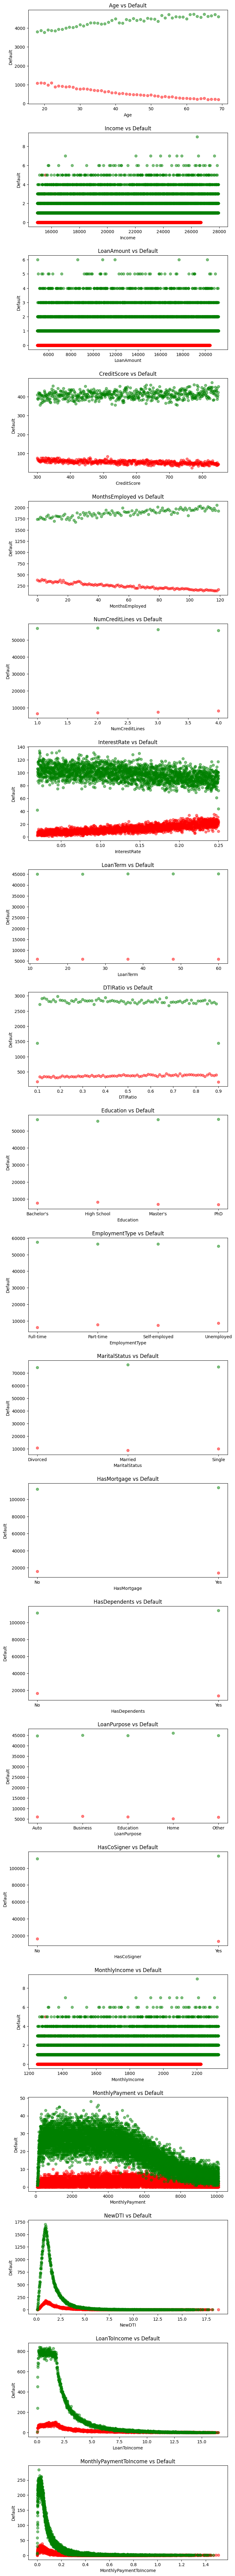

In [114]:
column_names = [col for col in train_df.columns if col not in ['Default', 'LoanID']]



num_columns = len(column_names)
fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(8, 4 * num_columns))

# Loop through columns and plot
for i, col in enumerate(column_names):
    data = train_df.groupby(col)['Default'].sum().head(10000)
    data_no = train_df[train_df['Default'] == False].groupby(col)['Default'].count().head(10000)
    ax = axes[i]
    ax.scatter(data.index, data, alpha=0.5, color='red')
    ax.scatter(data_no.index, data_no, alpha=0.5, color='green')
    ax.set_xlabel(col)
    ax.set_ylabel('Default')
    ax.set_title(f'{col} vs Default')

plt.tight_layout(pad=2.0)
# plt.plot(train_df.groupby('Age')['Default'].sum().head(1000))
# plt.plot(train_df[train_df['Default'] == False].groupby('Age')['Default'].count().head(1000))

In [115]:
train_df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,MonthlyIncome,MonthlyPayment,NewDTI,LoanToIncome,MonthlyPaymentToIncome
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,0.134928,36.025894,0.500212,0.116128,6874.942054,5649.062683,1.657498,2.177481,0.096441
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,0.066364,16.969330,0.230917,0.320379,3246.917814,4731.401749,1.484102,2.178361,0.122200
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,0.020000,12.000000,0.100000,0.000000,1250.000000,91.000000,0.110000,0.030000,0.000700
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,0.077700,24.000000,0.300000,0.000000,4068.790000,2317.000000,0.840000,0.800000,0.028000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,0.134600,36.000000,0.500000,0.000000,6872.170000,4442.000000,1.220000,1.550000,0.056900
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,0.192500,48.000000,0.700000,0.000000,9684.920000,7260.000000,1.930000,2.670000,0.116500
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,0.250000,60.000000,0.900000,1.000000,12499.920000,23736.000000,18.750000,16.530000,1.507200


## Make predictions (required)

Remember you should create a dataframe named `prediction_df` with exactly 109,435 entries plus a header row attempting to predict the likelihood of borrowers to default on their loans in `test_df`. Your submission will throw an error if you have extra columns (beyond `LoanID` and `predicted_probaility`) or extra rows.

The file should have exactly 2 columns:
`LoanID` (sorted in any order)
`predicted_probability` (contains your numeric predicted probabilities between 0 and 1, e.g. from `estimator.predict_proba(X, y)[:, 1]`)

The naming convention of the dataframe and columns are critical for our autograding, so please make sure to use the exact naming conventions of `prediction_df` with column names `LoanID` and `predicted_probability`!

### Example prediction submission:

The code below is a very naive prediction method that simply predicts loan defaults using a Dummy Classifier. This is used as just an example showing the submission format required. Please change/alter/delete this code below and create your own improved prediction methods for generating `prediction_df`.

**PLEASE CHANGE CODE BELOW TO IMPLEMENT YOUR OWN PREDICTIONS**

In [119]:
TRAIN_SIZE=0.7

REMOVE_FEATURES = ['Default', 'LoanID']
# REMOVE_FEATURES = ['CreditScore','CreditUtilizationRate', 'Default', 'LoanID', 'HasCoSigner', 'LoanPurpose', 'HasDependents', 'HasMortgage', 'MaritalStatus', 'EmploymentType', 'Education', 'LoanTerm', 'NumCreditLines' ]
TEXT_COLUMNS = ['LoanPurpose', 'MaritalStatus']
YES_NO_COLUMNS =  ['HasMortgage', 'HasDependents', 'HasCoSigner']
def one_hot(df, columns):
    one_hot_tensors = []
    one_hot_columns = []

    if len(columns) == 0:
        return df
    for col in columns:
        print(col)
        categories = df[col].unique()
        category_to_index = {category: index for index, category in enumerate(categories)}
        df[col] = df[col].map(category_to_index)
        num_categories = len(categories)
        one_hot_encoding = torch.nn.functional.one_hot(torch.tensor(df[col]), num_classes=num_categories)
        one_hot_df = pd.DataFrame(one_hot_encoding.numpy(), columns=categories)
        df = pd.concat([df, one_hot_df], axis=1)

    return df

    

def transform_education(df):
    if 'Education' in REMOVE_FEATURES:
        return
    education_mapping = {
        'High School': 0,
        "Bachelor's" : 1,
        "Master's": 2,
        'PhD': 3
    }

    df['Education'] = df['Education'].replace(education_mapping)

def transform_empoloyment(df):
    if 'EmploymentType' in REMOVE_FEATURES:
        return
    mapping = {
        'Unemployed': 0,
        'Part-time': 1,
        'Self-employed': 2,
        'Full-time': 3,
    }
    df['EmploymentType'] = df['EmploymentType'].replace(mapping)



def transform_data(df):
    train_df_tmp = df.loc[:, ~df.columns.isin(REMOVE_FEATURES)]
    train_df_tmp = one_hot(train_df_tmp, set(TEXT_COLUMNS) - set(REMOVE_FEATURES))
    transform_education(train_df_tmp)
    transform_empoloyment(train_df_tmp)

    for yes_no_column in set(YES_NO_COLUMNS) - set(REMOVE_FEATURES):
        train_df_tmp[yes_no_column] = df[yes_no_column].replace({'Yes': 1, 'No': 0})

    return train_df_tmp

y_train = train_df['Default'].to_numpy()
x_train_transformed = transform_data(train_df)

x_train, x_val, y_train, y_val = train_test_split(x_train_transformed.to_numpy(), y_train, train_size=TRAIN_SIZE)
x_test = transform_data(test_df)
feature_len = x_train.shape[1]


MaritalStatus


/var/folders/f1/mp3z168928qf5jyrxycz886w0000gn/T/ipykernel_95402/4021612990.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(category_to_index)


LoanPurpose
MaritalStatus
LoanPurpose


/var/folders/f1/mp3z168928qf5jyrxycz886w0000gn/T/ipykernel_95402/4021612990.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(category_to_index)


In [120]:
print(f'{len(x_train)}, {len(y_train)}')

178742, 178742


In [121]:
print(x_train_transformed.dtypes)

Age                         int64
Income                      int64
LoanAmount                  int64
CreditScore                 int64
MonthsEmployed              int64
NumCreditLines              int64
InterestRate              float64
LoanTerm                    int64
DTIRatio                  float64
Education                   int64
EmploymentType              int64
MaritalStatus               int64
HasMortgage                 int64
HasDependents               int64
LoanPurpose                 int64
HasCoSigner                 int64
MonthlyIncome             float64
MonthlyPayment            float64
NewDTI                    float64
LoanToIncome              float64
MonthlyPaymentToIncome    float64
Divorced                    int64
Married                     int64
Single                      int64
Other                       int64
Auto                        int64
Business                    int64
Home                        int64
Education                   int64
dtype: object


In [122]:
x_train_transformed[:1]

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,...,LoanToIncome,MonthlyPaymentToIncome,Divorced,Married,Single,Other,Auto,Business,Home,Education
0,56,85994,50587,520,80,4,0.1523,36,0.44,1,...,0.59,0.0205,1,0,0,1,0,0,0,0


In [123]:
def create_dataloader(x, y, batch_size=32):
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)

    # Normalize each feature independently
    x_normalized = (x - x_mean) / x_std
    x_tensor = torch.tensor(x_normalized, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

train_loader = create_dataloader(x_train, y_train)
val_loader = create_dataloader(x_val, y_val)

In [148]:
class LoanDefaultPredictor(nn.Module):
    def __init__(self, input_size):
      super(LoanDefaultPredictor, self).__init__()
      self.fc1 = nn.Linear(input_size, 128)
      self.drop1 = nn.Dropout(0.2)
      self.fc2 = nn.Linear(128, 64)
      self.drop2 = nn.Dropout(0.2)
      self.fc3 = nn.Linear(64, 32)
      self.drop3 = nn.Dropout(0.2)
      self.out = nn.Linear(32,1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.drop1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x = self.drop2(x)
      x = F.relu(x)
      x = self.fc3(x)
      x = self.drop3(x)
      x = F.relu(x)
      x = self.out(x)
      x = F.sigmoid(x)
      return x
      
model = LoanDefaultPredictor(input_size=feature_len)

In [153]:
optimizer = torch.optim.Adam(model.parameters(), lr =0.001)
loss = torch.nn.BCELoss()
accuracy = Accuracy('binary')

In [154]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    acc = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    with tqdm(total=len(train_loader)) as pbar:
        accuracy.reset()
        for i, data in enumerate(train_loader):
            # Every data instance is an input + label pair
            inputs, labels = data

            
            
            # Zero your gradients for every batch!
            optimizer.zero_grad()
            
            # Make predictions for this batch
            outputs = model(inputs)
            
            accuracy.update(outputs, labels)
            # Compute the loss and its gradients
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            # Adjust learning weights
            optimizer.step()
            
            # Gather data and report
            running_loss += loss.item()
            if i % 1000 == 999:
                acc = accuracy.compute()
                last_loss = running_loss / 1000 # loss per batch
                pbar.set_description(f'loss: {last_loss:.4f}, acc: {acc:.4f}')
                tb_x = epoch_index * len(train_loader) + i + 1
                tb_writer.add_scalars('train loss', {'loss': last_loss} , tb_x)
                tb_writer.add_scalars('train acc', {'acc': acc} , tb_x)
                running_loss = 0.
                accuracy.reset()
            pbar.update()
            
    return last_loss, acc

In [155]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/loan_default_trainer{}'.format(timestamp))
epoch_number = 0

In [156]:
EPOCHS = 50

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, acc = train_one_epoch(epoch_number, writer)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    accuracy.reset()
    for i, vdata in enumerate(val_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
        accuracy.update(voutputs, vlabels)
    
    val_acc = accuracy.compute()
    avg_vloss = running_vloss / (i + 1)
    print(f'loss {avg_loss:.4f}, val_loss {avg_vloss:.4f}, acc: {acc}, val_acc: {val_acc:.4f}')
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Loss',
                    { 'loss' : avg_loss, 'val_loss' : avg_vloss},
                    epoch_number + 1)
    writer.add_scalars('Acc',
                    { 'acc' : acc, 'val_acc' : val_acc},
                    epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

EPOCH 1:


loss: 0.3136, acc: 0.8864: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1459.80it/s]


loss 0.3136, val_loss 0.3163, acc: 0.8864062428474426, val_acc: 0.8852
EPOCH 2:


loss: 0.3120, acc: 0.8862: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1502.85it/s]


loss 0.3120, val_loss 0.3168, acc: 0.8862187266349792, val_acc: 0.8834
EPOCH 3:


loss: 0.3151, acc: 0.8852: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1489.05it/s]


loss 0.3151, val_loss 0.3168, acc: 0.8851875066757202, val_acc: 0.8853
EPOCH 4:


loss: 0.3097, acc: 0.8875: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1518.24it/s]


loss 0.3097, val_loss 0.3161, acc: 0.8875312209129333, val_acc: 0.8850
EPOCH 5:


loss: 0.3084, acc: 0.8888: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1494.05it/s]


loss 0.3084, val_loss 0.3157, acc: 0.8888124823570251, val_acc: 0.8852
EPOCH 6:


loss: 0.3123, acc: 0.8864: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1535.43it/s]


loss 0.3123, val_loss 0.3163, acc: 0.8864062428474426, val_acc: 0.8853
EPOCH 7:


loss: 0.3191, acc: 0.8842: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1541.01it/s]


loss 0.3191, val_loss 0.3165, acc: 0.8841875195503235, val_acc: 0.8841
EPOCH 8:


loss: 0.3155, acc: 0.8859: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1502.26it/s]


loss 0.3155, val_loss 0.3175, acc: 0.8859062790870667, val_acc: 0.8846
EPOCH 9:


loss: 0.3120, acc: 0.8858: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1499.41it/s]


loss 0.3120, val_loss 0.3166, acc: 0.885812520980835, val_acc: 0.8839
EPOCH 10:


loss: 0.3121, acc: 0.8857: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1518.55it/s]


loss 0.3121, val_loss 0.3174, acc: 0.8856874704360962, val_acc: 0.8841
EPOCH 11:


loss: 0.3175, acc: 0.8827: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1476.07it/s]


loss 0.3175, val_loss 0.3172, acc: 0.8826562762260437, val_acc: 0.8855
EPOCH 12:


loss: 0.3103, acc: 0.8884: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1519.45it/s]


loss 0.3103, val_loss 0.3155, acc: 0.8884062767028809, val_acc: 0.8855
EPOCH 13:


loss: 0.3105, acc: 0.8869: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1436.34it/s]


loss 0.3105, val_loss 0.3170, acc: 0.8869062662124634, val_acc: 0.8837
EPOCH 14:


loss: 0.3124, acc: 0.8852: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1491.94it/s]


loss 0.3124, val_loss 0.3163, acc: 0.8851562738418579, val_acc: 0.8844
EPOCH 15:


loss: 0.3135, acc: 0.8861: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1447.15it/s]


loss 0.3135, val_loss 0.3167, acc: 0.8860937356948853, val_acc: 0.8847
EPOCH 16:


loss: 0.3105, acc: 0.8877: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1429.40it/s]


loss 0.3105, val_loss 0.3178, acc: 0.8877187371253967, val_acc: 0.8831
EPOCH 17:


loss: 0.3125, acc: 0.8856: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1488.17it/s]


loss 0.3125, val_loss 0.3171, acc: 0.8855624794960022, val_acc: 0.8835
EPOCH 18:


loss: 0.3104, acc: 0.8892: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1548.22it/s]


loss 0.3104, val_loss 0.3162, acc: 0.8891562223434448, val_acc: 0.8855
EPOCH 19:


loss: 0.3149, acc: 0.8834: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1520.47it/s]


loss 0.3149, val_loss 0.3180, acc: 0.8834375143051147, val_acc: 0.8851
EPOCH 20:


loss: 0.3136, acc: 0.8861: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1465.52it/s]


loss 0.3136, val_loss 0.3160, acc: 0.8860937356948853, val_acc: 0.8853
EPOCH 21:


loss: 0.3092, acc: 0.8878: 100%|████████████████████████████████████████████████████████████████| 5586/5586 [17:39<00:00,  5.27it/s]


loss 0.3092, val_loss 0.3174, acc: 0.8877812623977661, val_acc: 0.8837
EPOCH 22:


loss: 0.3053, acc: 0.8898: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1516.59it/s]


loss 0.3053, val_loss 0.3167, acc: 0.889843761920929, val_acc: 0.8846
EPOCH 23:


loss: 0.3072, acc: 0.8886: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1436.64it/s]


loss 0.3072, val_loss 0.3165, acc: 0.8885937333106995, val_acc: 0.8849
EPOCH 24:


loss: 0.3140, acc: 0.8857: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1484.53it/s]


loss 0.3140, val_loss 0.3189, acc: 0.8857499957084656, val_acc: 0.8848
EPOCH 25:


loss: 0.3146, acc: 0.8851: 100%|███████████████████████████████████████████████████████████████| 5586/5586 [00:23<00:00, 242.85it/s]


loss 0.3146, val_loss 0.3190, acc: 0.8851249814033508, val_acc: 0.8845
EPOCH 26:


loss: 0.3082, acc: 0.8887: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1536.51it/s]


loss 0.3082, val_loss 0.3167, acc: 0.8887187242507935, val_acc: 0.8846
EPOCH 27:


loss: 0.3134, acc: 0.8856: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1464.20it/s]


loss 0.3134, val_loss 0.3187, acc: 0.8855937719345093, val_acc: 0.8849
EPOCH 28:


loss: 0.3097, acc: 0.8885: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1511.58it/s]


loss 0.3097, val_loss 0.3163, acc: 0.8884687423706055, val_acc: 0.8849
EPOCH 29:


loss: 0.3140, acc: 0.8850: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1521.31it/s]


loss 0.3140, val_loss 0.3179, acc: 0.8849687576293945, val_acc: 0.8830
EPOCH 30:


loss: 0.3117, acc: 0.8881: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1482.93it/s]


loss 0.3117, val_loss 0.3167, acc: 0.8881250023841858, val_acc: 0.8852
EPOCH 31:


loss: 0.3121, acc: 0.8860: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1459.89it/s]


loss 0.3121, val_loss 0.3179, acc: 0.8859999775886536, val_acc: 0.8854
EPOCH 32:


loss: 0.3093, acc: 0.8889: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1503.70it/s]


loss 0.3093, val_loss 0.3178, acc: 0.8889374732971191, val_acc: 0.8838
EPOCH 33:


loss: 0.3136, acc: 0.8852: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1509.83it/s]


loss 0.3136, val_loss 0.3175, acc: 0.8851562738418579, val_acc: 0.8844
EPOCH 34:


loss: 0.3111, acc: 0.8875: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1464.71it/s]


loss 0.3111, val_loss 0.3184, acc: 0.8874687552452087, val_acc: 0.8855
EPOCH 35:


loss: 0.3067, acc: 0.8892: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1488.76it/s]


loss 0.3067, val_loss 0.3164, acc: 0.8891875147819519, val_acc: 0.8855
EPOCH 36:


loss: 0.3096, acc: 0.8873: 100%|████████████████████████████████████████████████████████████████| 5586/5586 [07:06<00:00, 13.10it/s]


loss 0.3096, val_loss 0.3168, acc: 0.8872812390327454, val_acc: 0.8855
EPOCH 37:


loss: 0.3072, acc: 0.8888: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:04<00:00, 1390.01it/s]


loss 0.3072, val_loss 0.3163, acc: 0.8888437747955322, val_acc: 0.8856
EPOCH 38:


loss: 0.3125, acc: 0.8865: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1456.70it/s]


loss 0.3125, val_loss 0.3173, acc: 0.8865312337875366, val_acc: 0.8857
EPOCH 39:


loss: 0.3101, acc: 0.8864: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1431.07it/s]


loss 0.3101, val_loss 0.3172, acc: 0.8863750100135803, val_acc: 0.8856
EPOCH 40:


loss: 0.3087, acc: 0.8878: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1542.62it/s]


loss 0.3087, val_loss 0.3181, acc: 0.8878124952316284, val_acc: 0.8847
EPOCH 41:


loss: 0.3142, acc: 0.8843: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1534.80it/s]


loss 0.3142, val_loss 0.3175, acc: 0.8843125104904175, val_acc: 0.8843
EPOCH 42:


loss: 0.3081, acc: 0.8884: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1497.82it/s]


loss 0.3081, val_loss 0.3174, acc: 0.8884062767028809, val_acc: 0.8844
EPOCH 43:


loss: 0.3099, acc: 0.8867: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1457.22it/s]


loss 0.3099, val_loss 0.3181, acc: 0.8866875171661377, val_acc: 0.8835
EPOCH 44:


loss: 0.3169, acc: 0.8837: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1434.83it/s]


loss 0.3169, val_loss 0.3172, acc: 0.8836874961853027, val_acc: 0.8853
EPOCH 45:


loss: 0.3098, acc: 0.8862: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1448.97it/s]


loss 0.3098, val_loss 0.3178, acc: 0.8861562609672546, val_acc: 0.8847
EPOCH 46:


loss: 0.3097, acc: 0.8874: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1441.23it/s]


loss 0.3097, val_loss 0.3173, acc: 0.8874062299728394, val_acc: 0.8857
EPOCH 47:


loss: 0.3092, acc: 0.8889: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1458.47it/s]


loss 0.3092, val_loss 0.3189, acc: 0.8889062404632568, val_acc: 0.8831
EPOCH 48:


loss: 0.3087, acc: 0.8893: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1454.92it/s]


loss 0.3087, val_loss 0.3170, acc: 0.8893437385559082, val_acc: 0.8856
EPOCH 49:


loss: 0.3096, acc: 0.8872: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1434.19it/s]


loss 0.3096, val_loss 0.3184, acc: 0.8871874809265137, val_acc: 0.8837
EPOCH 50:


loss: 0.3121, acc: 0.8860: 100%|██████████████████████████████████████████████████████████████| 5586/5586 [00:03<00:00, 1463.27it/s]


loss 0.3121, val_loss 0.3200, acc: 0.8859687447547913, val_acc: 0.8831


In [ ]:
predicted_probability = best_model.predict(x_train)
# x_range=np.arange(len(predicted_probability))
length = 10
x_range=np.arange(length)

plt.scatter(x_range[:length], predicted_probability[:length], color='blue')
plt.scatter(x_range[:length], y_train[:length], color='green')

In [ ]:
predicted_probability

In [ ]:

test_ds = transform_data(test_df)
predicted_probability = best_model.predict(x_test)

In [ ]:
predicted_probability

In [ ]:
prediction_df = pd.DataFrame({'LoanID': test_df[['LoanID']].values[:, 0],
                             'predicted_probability': tf.squeeze(predicted_probability)})

In [ ]:
### PLEASE CHANGE THIS CODE TO IMPLEMENT YOUR OWN PREDICTIONS

# View our 'prediction_df' dataframe as required for submission.
# Ensure it should contain 104,480 rows and 2 columns 'CustomerID' and 'predicted_probaility'
print(prediction_df.shape)
prediction_df.head(10)

**PLEASE CHANGE CODE ABOVE TO IMPLEMENT YOUR OWN PREDICTIONS**

## Final Tests - **IMPORTANT** - the cells below must be run prior to submission

Below are some tests to ensure your submission is in the correct format for autograding. The autograding process accepts a csv `prediction_submission.csv` which we will generate from our `prediction_df` below. Please run the tests below an ensure no assertion errors are thrown.

In [ ]:
# FINAL TEST CELLS - please make sure all of your code is above these test cells

# Writing to csv for autograding purposes
prediction_df.to_csv("prediction_submission.csv", index=False)
submission = pd.read_csv("prediction_submission.csv")

assert isinstance(submission, pd.DataFrame), 'You should have a dataframe named prediction_df.'

In [ ]:
# FINAL TEST CELLS - please make sure all of your code is above these test cells

assert submission.columns[0] == 'LoanID', 'The first column name should be CustomerID.'
assert submission.columns[1] == 'predicted_probability', 'The second column name should be predicted_probability.'

In [ ]:
# FINAL TEST CELLS - please make sure all of your code is above these test cells

assert submission.shape[0] == 109435, 'The dataframe prediction_df should have 109435 rows.'

In [ ]:
# FINAL TEST CELLS - please make sure all of your code is above these test cells

assert submission.shape[1] == 2, 'The dataframe prediction_df should have 2 columns.'

In [ ]:
# FINAL TEST CELLS - please make sure all of your code is above these test cells

## This cell calculates the auc score and is hidden. Submit Assignment to see AUC score.

## SUBMIT YOUR WORK!

Once we are happy with our `prediction_df` and `prediction_submission.csv` we can now submit for autograding! Submit by using the blue **Submit Assignment** at the top of your notebook. Don't worry if your initial submission isn't perfect as you have multiple submission attempts and will obtain some feedback after each submission!